In [1]:
# import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from functools import reduce
from IPython.display import display_html
import scipy.stats

In [2]:
plt.style.use('fivethirtyeight')

# Discovery

PROBLEM: reliability and racism among US police.

OBJECTIVE: identify trends and highlights in gunshot homicide cases by US police. 

# Data Selection

SOURCES:
+ https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us
+ https://drive.google.com/file/d/1kEikaWCZYVO3ygVvAuVqxYqQPaVJrdYb/view
+ https://github.com/washingtonpost/data-police-shootings


In [3]:
'''
Fatal Police Shooting Washington Post dataset:
    dataset of gunshot omicide cases by US police, between 2015 and 2022
'''

fps = pd.read_csv('https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv',
                 parse_dates=True)
'''
USA population dataset:
    dataset of USA population per city
'''

url = 'https://drive.google.com/file/d/1kEikaWCZYVO3ygVvAuVqxYqQPaVJrdYb/view'
pop = pd.read_csv('https://drive.google.com/uc?id=' + url.split('/')[-2])

'''
Racial demographics dataset
       dataset of ethnical percentage per city in the USA
'''
rac = pd.read_csv('archive/ShareRaceByCity.csv')

'''
Poverty rate dataset
    dataset of poverty rate per city in the USA 
'''

pov = pd.read_csv('archive/PercentagePeopleBelowPovertyLevel.csv',
                  encoding='latin')
'''
High school graduation rate dataset
    dataset of graduation rate per city in the USA
'''

grad = pd.read_csv('archive/PercentOver25CompletedHighSchool.csv',
                   encoding='latin')

'''
Median household income 2015 dataset
    dataset of family median income per city in the USA
'''
inc = pd.read_csv('archive/MedianHouseholdIncome2015.csv',
                  encoding='latin')

In [4]:
fps.head(2)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True


In [5]:
pop.head(2)

,city,state,population,lat,lng
0,Anchor Point,AK,2057.0,59.7703,-151.7052
1,Anchorage,AK,253421.0,61.1508,-149.1091


In [6]:
rac.head(2)

,Geographic area,City,share_white,share_black,share_native_american,share_asian,share_hispanic
0,AL,Abanda CDP,67.2,30.2,0,0,1.6
1,AL,Abbeville city,54.4,41.4,0.1,1,3.1


In [7]:
pov.head(2)

,Geographic Area,City,poverty_rate
0,AL,Abanda CDP,78.8
1,AL,Abbeville city,29.1


In [8]:
grad.head(2)

,Geographic Area,City,percent_completed_hs
0,AL,Abanda CDP,21.2
1,AL,Abbeville city,69.1


In [9]:
inc.head(2)

,Geographic Area,City,Median Income
0,AL,Abanda CDP,11207
1,AL,Abbeville city,25615


In [10]:
# preprocessing dei DataFrame aggiuntivi

def float_or_nan(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

dfs = [rac, pov, grad, inc] # NB: pop è già ok 

# rac, pov, grad, inc:
for i in range(len(dfs)): 
    
    # rinomino colonne in modo che abbiano lo stesso nome nei diversi df
    dfs[i] = dfs[i].rename(columns={'Geographic area':'state', 'Geographic Area':'state', 'City':'city'})

    # cast str --> float (sostituisco valori non numerici con NaN)
    dfs[i].iloc[:, 2:] = dfs[i].iloc[:, 2:].applymap(float_or_nan)
    
    # elimino parte tra parentesi nel nome delle città (es. '(county of ...)') in modo da uniformare
    dfs[i].city = dfs[i].city.apply(lambda x: x[:x.index(' (')] + x[x.index(')'):] if '(' in x else x)

    # elimino ultima parola ('city', 'town', 'village', ...) nel nome delle città
    dfs[i].city = dfs[i].city.str.split(' ').apply(lambda x: ' '.join(x[:-1]))

    # gestisco elementi duplicati
    dfs[i] = dfs[i].groupby(['state', 'city']).mean().reset_index()

rac, pov, grad, inc = dfs

In [11]:
# creo dataframe 'cities' con dati città USA
cities = reduce(lambda left, right: pd.merge(left, right, on=['state', 'city'], how='outer'),
                [pop, rac, pov, grad, inc])
cities = cities.set_index(['state', 'city'])

In [12]:
cities.head(20)

population      lat       lng  share_white  \
state city                                                          
AK    Anchor Point         2057.0  59.7703 -151.7052         90.2   
      Anchorage          253421.0  61.1508 -149.1091         66.0   
      Barrow               4178.0      NaN       NaN         16.9   
      Big Lake             3136.0  61.5260 -149.9721         86.1   
      Copper Center         397.0  61.9845 -145.3544         45.7   
      Fairbanks           64732.0  64.8353 -147.6534         66.1   
      Houston              2347.0  61.6159 -149.8003         82.2   
      Juneau              25180.0  58.4546 -134.1739          NaN   
      Kasilof               483.0  60.3310 -151.2293         87.8   
      Kenai Peninsula      4178.0      NaN       NaN          NaN   
      Nikolaevsk            279.0  59.8295 -151.5964         92.5   
      North Pole           2101.0  64.7530 -147.3600         79.6   
      Palmer               7209.0  61.5971 -149.1147         79.1   
      Pilot Station         620.0  61.9422 -162.8828          1.8   
      Seward               2831.0  60.1124 -149.3925         68.5   
      Spenard              4178.0      NaN       NaN          NaN   
      Wasilla             10151.0  61.5770 -149.4661         83.4   
AL    Abbeville            2567.0  31.5664  -85.2528         54.4   
      Albertville         37220.0  34.2634  -86.2107         75.9   
      Anniston            75169.0  33.6713  -85.8136         44.7   

                       share_black  share_native_american  share_asian  \
state city                                                               
AK    Anchor Point             0.3                    3.8          0.9   
      Anchorage                5.6                    7.9          8.1   
      Barrow                   1.0                   61.2          9.1   
      Big Lake                 0.2                    7.0          0.5   
      Copper Center            0.0                   48.5          0.3   
      Fairbanks                9.0                   10.0          3.6   
      Houston                  0.4                    6.7          0.6   
      Juneau                   NaN                    NaN          NaN   
      Kasilof                  0.2                    4.2          0.5   
      Kenai Peninsula          NaN                    NaN          NaN   
      Nikolaevsk               0.0                    3.5          0.3   
      North Pole               5.4                    3.4          4.0   
      Palmer                   1.8                    9.2          1.1   
      Pilot Station            0.0                   98.1          0.0   
      Seward                   3.1                   16.7          2.4   
      Spenard                  NaN                    NaN          NaN   
      Wasilla                  1.4                    5.2          2.1   
AL    Abbeville               41.4                    0.1          1.0   
      Albertville              1.9                    0.8          0.5   
      Anniston                51.5                    0.3          0.8   

                       share_hispanic  poverty_rate  percent_completed_hs  \
state city                                                                  
AK    Anchor Point                2.2          10.1                  93.8   
      Anchorage                   7.6           8.2                  93.0   
      Barrow                      3.1          11.7                  84.6   
      Big Lake                    3.1           9.6                  90.4   
      Copper Center               3.0          18.8                  84.8   
      Fairbanks                   9.0          13.1                  91.2   
      Houston                     3.3          14.8                  90.2   
      Juneau                      NaN           NaN                   NaN   
      Kasilof                     2.4           5.7                 100.0   
      Kenai Peninsula       

In [13]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 29828 entries, ('AK', 'Anchor Point') to ('TX', 'C_sar Chövez')
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   population             2832 non-null   float64
 1   lat                    2228 non-null   float64
 2   lng                    2228 non-null   float64
 3   share_white            29078 non-null  float64
 4   share_black            29078 non-null  float64
 5   share_native_american  29078 non-null  float64
 6   share_asian            29078 non-null  float64
 7   share_hispanic         29078 non-null  float64
 8   poverty_rate           28960 non-null  float64
 9   percent_completed_hs   28964 non-null  float64
 10  Median Income          27248 non-null  float64
dtypes: float64(11)
memory usage: 3.2+ MB


In [14]:
# converto campo 'date' da str a formato datetime
fps.date = pd.to_datetime(fps.date)

# Data Cleaning

In [15]:
fps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6846 entries, 0 to 6845
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       6846 non-null   int64         
 1   name                     6552 non-null   object        
 2   date                     6846 non-null   datetime64[ns]
 3   manner_of_death          6846 non-null   object        
 4   armed                    6639 non-null   object        
 5   age                      6496 non-null   float64       
 6   gender                   6838 non-null   object        
 7   race                     5858 non-null   object        
 8   city                     6846 non-null   object        
 9   state                    6846 non-null   object        
 10  signs_of_mental_illness  6846 non-null   bool          
 11  threat_level             6846 non-null   object        
 12  flee                     6294 non-

In [16]:
# conteggio valori nulli fps
fps.isna().sum()

id                           0
name                       294
date                         0
manner_of_death              0
armed                      207
age                        350
gender                       8
race                       988
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       552
body_camera                  0
longitude                  425
latitude                   425
is_geocoding_exact           0
dtype: int64

In [17]:
# imputazione dati mancanti (vittima)
fps.armed.fillna('undetermined', inplace=True)
fps.gender.fillna('unknown', inplace=True)
fps.race.fillna('unknown', inplace=True)
fps.flee.fillna('unknown', inplace=True)

# sostituzione valori per body_camera, signs_of_mental_illness, race
fps.body_camera = fps.body_camera.replace({True: 'Yes', False: 'No'})
fps.signs_of_mental_illness = fps.signs_of_mental_illness.replace({True: 'Yes', False: 'No'})
fps.race = fps.race.replace({'W':'white', 'B':'black', 'H':'hispanic', 'A':'asian', 'N':'native_american', 'O':'other'})

In [18]:
# conteggio valori nulli 'cities'
cities.isna().sum()

population               26996
lat                      27600
lng                      27600
share_white                750
share_black                750
share_native_american      750
share_asian                750
share_hispanic             750
poverty_rate               868
percent_completed_hs       864
Median Income             2580
dtype: int64

In [19]:
# imputazione dati mancanti (città)--> sostituisco con media di ogni stato

nan_features = ['population', 'poverty_rate', 'percent_completed_hs', 'Median Income',
                'share_white', 'share_black', 'share_asian', 'share_native_american', 'share_hispanic']

for feature in nan_features:
    mean_vals = cities.groupby('state')[feature].mean()
    x = cities.reset_index()[feature].fillna(cities.reset_index().state.map(mean_vals))
    x.index = cities[feature].index
    cities[feature] = x

In [20]:
cities.isna().sum()

population                   0
lat                      27600
lng                      27600
share_white                  0
share_black                  0
share_native_american        0
share_asian                  0
share_hispanic               0
poverty_rate                 0
percent_completed_hs         0
Median Income                0
dtype: int64

In [21]:
# creazione nuove feature
'''
def menaceFunc(row):
    if(row.threat_level == 'other' and
      row.armed_bool == 'No' and
      row.signs_of_mental_illness == 'No'):
        return 'No'
    else:
        return 'Yes'
'''
fps['armed_bool'] = fps.armed.drop(fps[fps.armed == 'undetermined'].index).apply(lambda x: 'Yes' if x != 'unarmed' else 'No')
fps['flee_bool'] = fps.flee.drop(fps[fps.flee == 'unknown'].index).apply(lambda x: 'No' if x == 'Not fleeing' else 'Yes')
#fps['menace'] = fps.apply(menaceFunc, axis=1)
fps['age_range'] = pd.cut(fps.age, [0, 18, 30, 45, 60, 100])
fps['year'] = pd.DatetimeIndex(fps.date).year

In [22]:
# creo dataframe finale, che per ogni caso di fps indica anche i dati della città corrispondente
fps = pd.merge(fps, cities, how='left', on=['state', 'city'])
fps.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,lat,lng,share_white,share_black,share_native_american,share_asian,share_hispanic,poverty_rate,percent_completed_hs,Median Income
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,asian,Shelton,WA,...,47.2188,-123.1127,78.9,0.8,3.7,1.1,19.2,28.6,80.1,37072.0
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,white,Aloha,OR,...,45.4920,-122.8726,70.9,2.6,1.0,8.9,21.1,14.9,88.1,65765.0
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,hispanic,Wichita,KS,...,37.6897,-97.3441,71.9,11.5,1.2,4.8,15.3,17.3,87.5,45947.0
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,white,San Francisco,CA,...,37.7562,-122.4430,48.5,6.1,0.5,33.3,15.1,13.2,87.0,81294.0
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,hispanic,Evans,CO,...,40.3660,-104.7389,76.5,0.9,1.2,0.9,43.1,16.6,76.3,47791.0


# Data Exploration

In [23]:
fps.drop(['id', 'longitude', 'latitude'], axis=1).describe()

,age,year,population,lat,lng,share_white,share_black,share_native_american,share_asian,share_hispanic,poverty_rate,percent_completed_hs,Median Income
count,6500.000000,6850.000000,6.707000e+03,5656.000000,5656.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000
mean,37.136615,2017.981752,9.149625e+05,36.574206,-98.243632,68.392803,14.679845,1.668998,4.089585,19.647874,19.481311,84.287365,48771.325435
std,12.983417,1.987283,2.433478e+06,5.429775,16.512688,19.658872,17.432043,6.179013,6.149979,19.750946,7.755145,7.747427,15571.154160
min,6.000000,2015.000000,0.000000e+00,19.496100,-162.882800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,12083.000000
25%,27.000000,2016.000000,1.224600e+04,33.508800,-112.452400,56.000000,2.500000,0.300241,0.900000,4.500000,14.590280,80.500000,39432.000000
50%,35.000000,2018.000000,8.201100e+04,35.975850,-95.390500,70.900000,7.000000,0.600000,2.200000,11.300000,19.200000,85.168000,46744.000000
75%,45.000000,2020.000000,4.694500e+05,39.864300,-83.992475,84.600000,21.500000,1.200000,4.500000,30.200000,23.700000,89.300000,54080.000000
max,92.000000,2022.000000,1.935492e+07,64.835300,-67.987400,100.000000,98.000000,100.000000,66.900000,98.900000,76.400000,100.000000,178765.000000


In [24]:
# FREQUENCY TABLE

def freqTable(col, return_=True, show=True, head=10, ascending=False):
    
    count = pd.crosstab(index=col, columns='count', colnames=[''])
    perc = round(pd.crosstab(index=col, columns='perc', colnames=[''], normalize=True)*100, 2).astype(str)+'%'
    
    if(show):
        display_html(count.join(perc).sort_values('count', ascending=ascending).head(head))

    if(return_):
        return count.join(perc)
    

# BAR CHART

def barchart(freq_table, orientation='vertical', figsize=(7,7), limit=None, title='', text_offset=None):
    
    if(limit == None):
        limit = freq_table.shape[0]
    
    to_plot = freq_table.sort_values('count', ascending=False)[:limit]

    plt.figure(figsize=figsize)
    
    if(orientation == 'horizontal'):
        plot = plt.barh
        to_plot = to_plot[::-1]
        if(text_offset == None):
            text_offset = 300
    else:
        plot = plt.bar
        if(text_offset == None):
            text_offset = 50
    
    _ = plot(to_plot.index, to_plot['count'].values)
    
    for index in to_plot.index[::-1]:
        
        # text coordinates
        x = index
        y = to_plot.loc[index, 'count'] + text_offset
        
        if(orientation == 'horizontal'):
            x, y = y, x

        plt.text(x, y,
                 to_plot.loc[index]['perc'],
                 ha='center')

    _ = plt.title(title)

## • Age

In [25]:
# age

fps.age.describe()

count    6500.000000
mean       37.136615
std        12.983417
min         6.000000
25%        27.000000
50%        35.000000
75%        45.000000
max        92.000000
Name: age, dtype: float64

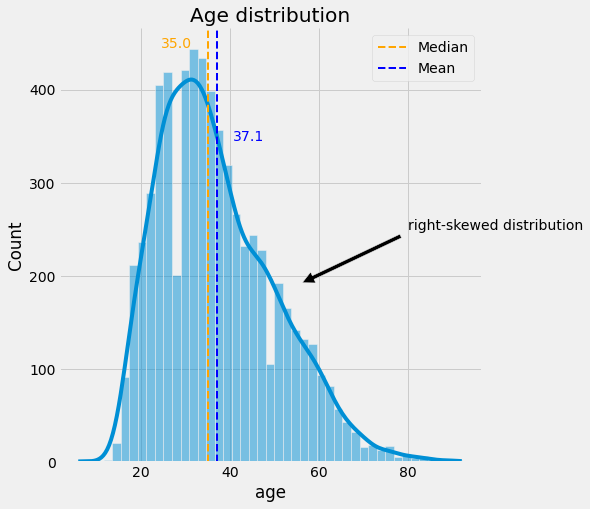

In [26]:
_ = sns.displot(fps.age, height=7, kde=True)

plt.axvline(fps.age.median(), color='orange', linewidth=2, label='Median', linestyle='--')
plt.text(fps.age.median() - 7, 445,
         str(round(fps.age.median(), 1)),
         ha='center',
         color='orange')

plt.axvline(fps.age.mean(), color='blue', linewidth=2, label='Mean', linestyle='--')
plt.text(fps.age.mean() + 7, 345,
         str(round(fps.age.mean(), 1)),
         ha='center',
         color='blue')

plt.annotate('right-skewed distribution', xy=(55, 190), xytext=(80, 250),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
_ = plt.title('Age distribution')

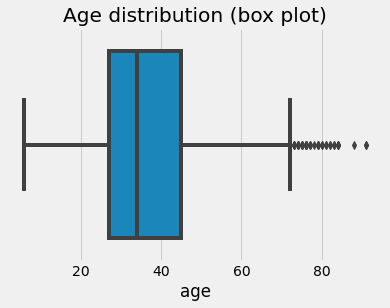

In [147]:
_ = sns.boxplot(x=fps.age)
_ = plt.title('Age distribution (box plot)')

In [149]:
# age range
freq_table = freqTable(fps.age_range, show=False)
freq_table.sort_index(ascending=True)

,count,perc
age_range,,
"(0, 18]",215,3.77%
"(18, 30]",1869,32.77%
"(30, 45]",2271,39.82%
"(45, 60]",1066,18.69%
"(60, 100]",282,4.94%


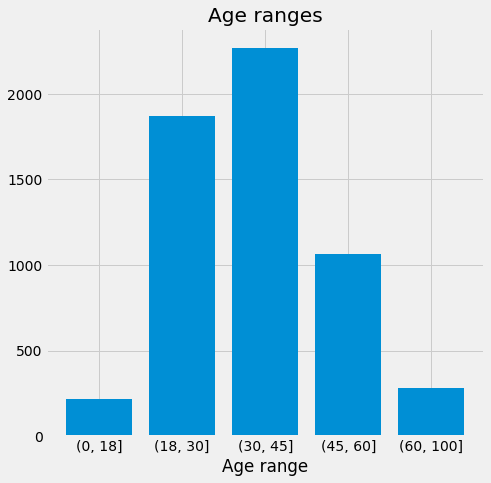

In [150]:
freq_table.index = freq_table.index.astype(str)

plt.figure(figsize=(7,7))
plt.bar(freq_table.index, freq_table['count'].values)
_ = plt.xlabel('Age range')
_ = plt.title('Age ranges')

## • Manner of Death

In [30]:
# FREQUENCY TABLE

freq_table = freqTable(fps.manner_of_death)

,count,perc
manner_of_death,,
shot,6515,95.11%
shot and Tasered,335,4.89%


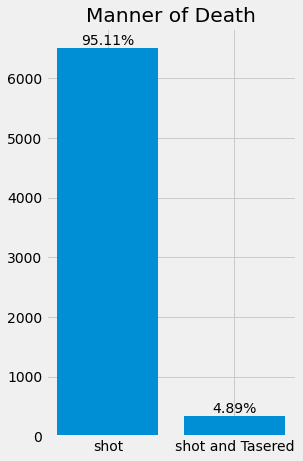

In [31]:
# BAR CHART

barchart(freq_table, orientation='vertical', figsize=(4,7), title='Manner of Death')

## • Armed

In [32]:
# FREQUENCY TABLE

freq_table = freqTable(fps.armed)

,count,perc
armed,,
gun,3939,57.5%
knife,991,14.47%
unarmed,429,6.26%
undetermined,412,6.01%
vehicle,231,3.37%
toy weapon,231,3.37%
unknown weapon,91,1.33%
machete,54,0.79%
Taser,36,0.53%


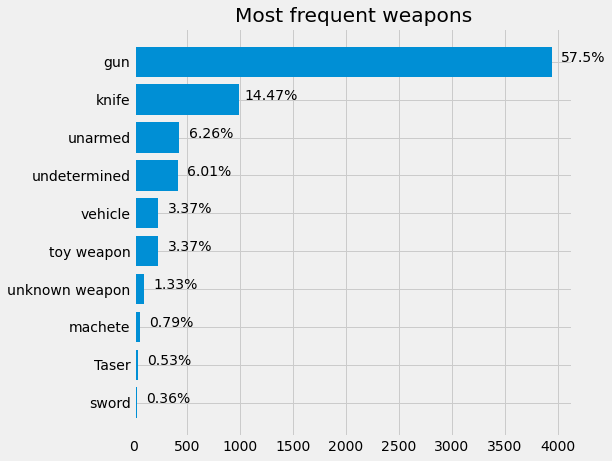

In [33]:
# BAR CHART

barchart(freq_table, orientation='horizontal', figsize=(7,7), limit=10, title='Most frequent weapons')

In [34]:
# armed / unarmed FREQ TABLE 

freq_table = freqTable(fps.armed_bool)

,count,perc
armed_bool,,
Yes,6009,93.34%
No,429,6.66%


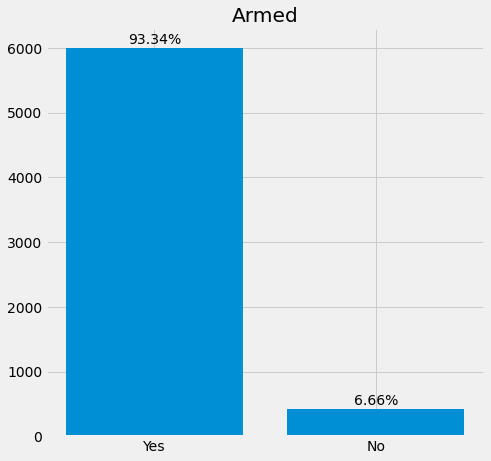

In [35]:
# armed / unarmed BARCHART

barchart(freq_table, title='Armed')

## • Gender

In [36]:
# FREQUENCY TABLE

freq_table = freqTable(fps.gender)

,count,perc
gender,,
M,6531,95.34%
F,311,4.54%
unknown,8,0.12%


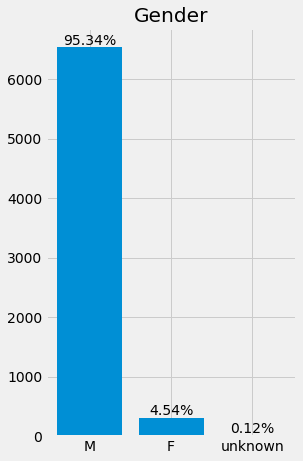

In [37]:
# BAR CHART

barchart(freq_table, orientation='vertical', figsize=(4,7), title='Gender')

## • Race

In [38]:
# FREQUENCY TABLE

freq_table = freqTable(fps.race)

,count,perc
race,,
white,2974,43.42%
black,1557,22.73%
hispanic,1084,15.82%
unknown,990,14.45%
asian,107,1.56%
native_american,91,1.33%
other,47,0.69%


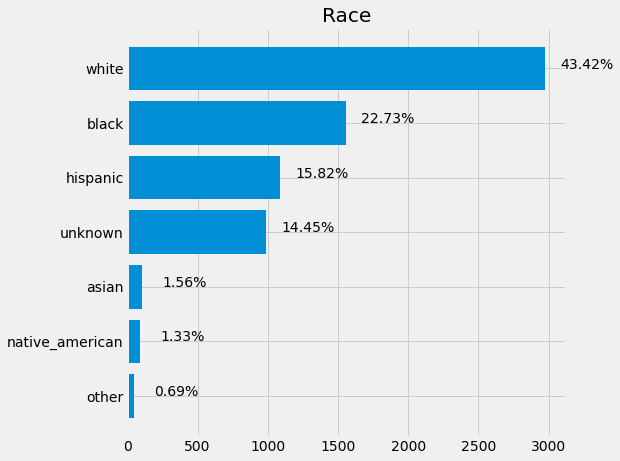

In [39]:
# BAR CHART

barchart(freq_table, orientation='horizontal', figsize=(7,7), title='Race')

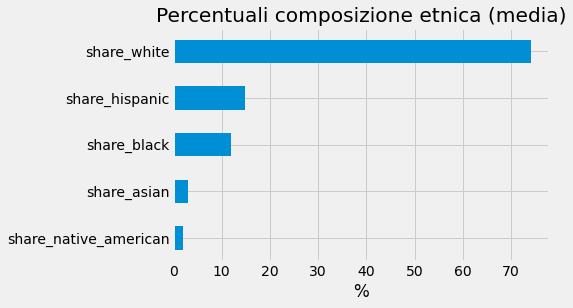

In [113]:
# percentuali composizione etnica (media)

fps.groupby('city')[['share_white', 'share_black', 'share_hispanic', 'share_asian', 'share_native_american']].mean().mean().sort_values().plot(kind='barh', title='Percentuali composizione etnica (media)')
_ = plt.xlabel('%')

## • State

In [41]:
# FREQUENCY TABLE

freq_table = freqTable(fps.state, head=20)

,count,perc
state,,
CA,1002,14.63%
TX,604,8.82%
FL,444,6.48%
AZ,310,4.53%
GA,252,3.68%
CO,248,3.62%
NC,195,2.85%
OK,194,2.83%
OH,192,2.8%


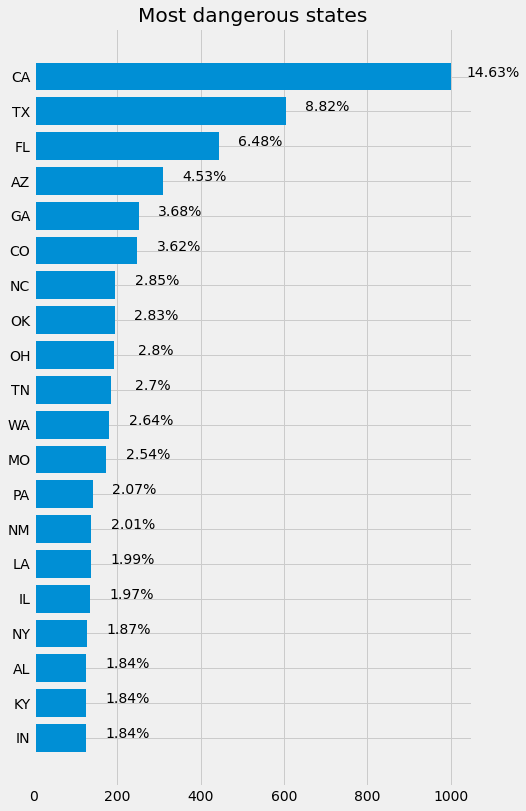

In [42]:
# BAR CHART

barchart(freq_table, orientation='horizontal', figsize=(7,13), limit=20, title='Most dangerous states', text_offset=100)

## • Cities

In [43]:
# FREQUENCY TABLE

freq_table = freqTable(fps.city, head=20)

,count,perc
city,,
Los Angeles,107,1.56%
Phoenix,94,1.37%
Houston,74,1.08%
Las Vegas,61,0.89%
San Antonio,61,0.89%
Chicago,47,0.69%
Columbus,45,0.66%
Albuquerque,44,0.64%
Denver,42,0.61%


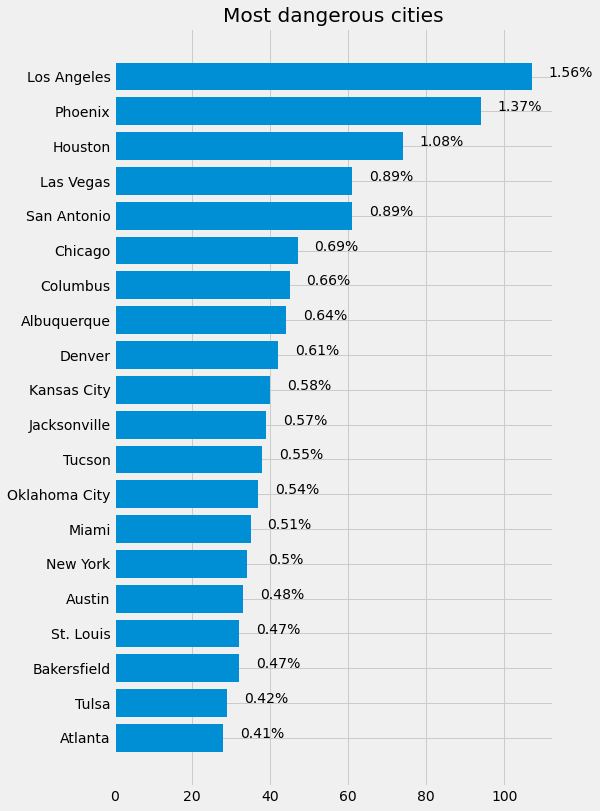

In [44]:
# BAR CHART

barchart(freq_table, orientation='horizontal', figsize=(7,13), text_offset=10, limit=20, title='Most dangerous cities')

## • Signs of mental ilness

In [45]:
# FREQUENCY TABLE

freq_table = freqTable(fps.signs_of_mental_illness)

,count,perc
signs_of_mental_illness,,
No,5319,77.65%
Yes,1531,22.35%


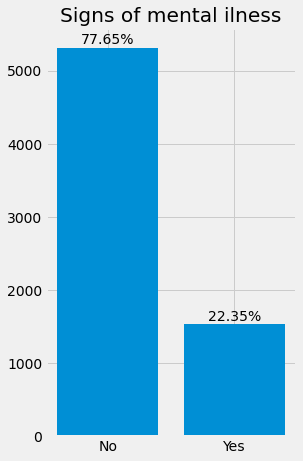

In [46]:
# BAR CHART

barchart(freq_table, orientation='vertical', figsize=(4,7), title='Signs of mental ilness')

## • Threat Level

In [47]:
# FREQUENCY TABLE

freq_table = freqTable(fps.threat_level)

,count,perc
threat_level,,
attack,4407,64.34%
other,2216,32.35%
undetermined,227,3.31%


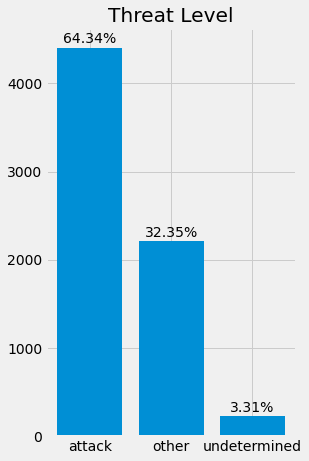

In [48]:
# BAR CHART

barchart(freq_table, orientation='vertical', figsize=(4,7), title='Threat Level')

## • Flee

In [49]:
# FREQUENCY TABLE

freq_table = freqTable(fps.flee)

,count,perc
flee,,
Not fleeing,4058,59.24%
Car,1112,16.23%
Foot,872,12.73%
unknown,552,8.06%
Other,256,3.74%


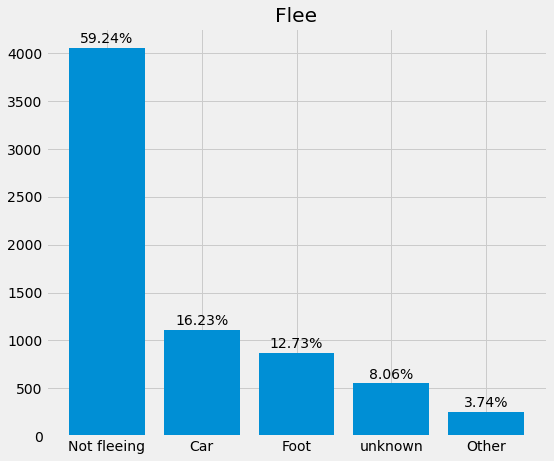

In [50]:
# BAR CHART

barchart(freq_table, orientation='vertical', figsize=(8,7), title='Flee')

In [51]:
# FREQ TABLE

freq_table = freqTable(fps.flee_bool)

,count,perc
flee_bool,,
No,4058,64.43%
Yes,2240,35.57%


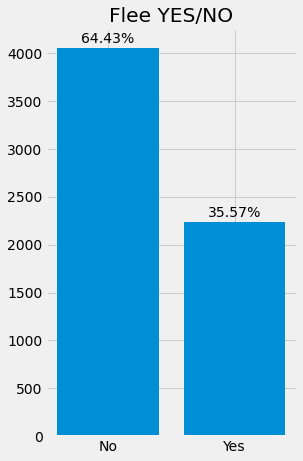

In [52]:
# BAR CHART

barchart(freq_table, orientation='vertical', figsize=(4,7), title='Flee YES/NO')

## • Body Camera

In [53]:
# FREQUENCY TABLE

freq_table = freqTable(fps.body_camera)

,count,perc
body_camera,,
No,5898,86.1%
Yes,952,13.9%


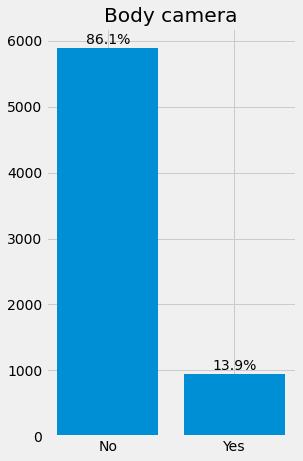

In [54]:
# BAR CHART

barchart(freq_table, orientation='vertical', figsize=(4,7), title='Body camera')

Over 72% of victims of gunshot omicide by US police is aged between 18 and 45, male (95%), white (43%). The typical case involves an armed subject (+93%) with a gun (57%), which in 22% of the cases gives signs of mental illness, in 36% of the cases is fleeing, in 64% of the cases the threat level is classified as an attack. The most affected state is California, where have occurred 14% of the cases (1.56% just in Los Angeles). Is also meaningful that in just 14% of the cases the police officier wore a bodycam.

## Multivariate Analysis

Victim data:
- Age
- Gender
- Race

Context data:
- Armed
- Threat level
- Flee
- Mental illness
- (Bodycam)

### a) Victim Data

#### • Age VS Gender

No handles with labels found to put in legend.


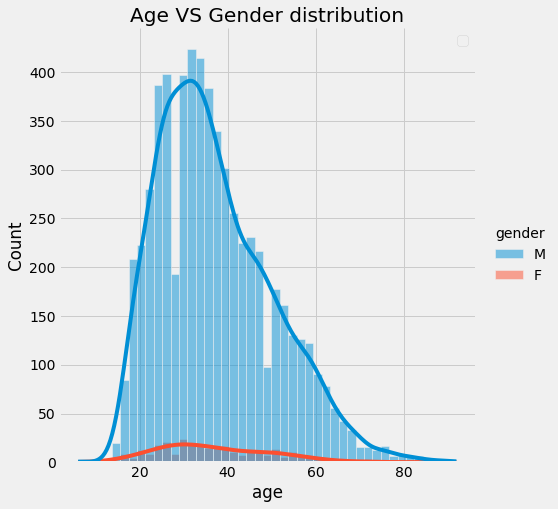

In [57]:
_ = sns.displot(data=fps[fps.gender != 'unknown'], x='age', height=7, kde=True, hue='gender')

plt.legend()
_ = plt.title('Age VS Gender distribution')

#### • Gender VS Race

In [58]:
# CONTINGENCY TABLE

cont_table = pd.crosstab(fps.race, fps.gender, normalize='index', margins=True)
cont_table = round(cont_table * 100).astype(str) + '%'
cont_table = cont_table.drop('unknown', axis=1)
cont_table

gender,F,M
race,,
asian,5.0%,95.0%
black,3.0%,97.0%
hispanic,3.0%,97.0%
native_american,5.0%,95.0%
other,6.0%,94.0%
unknown,4.0%,96.0%
white,6.0%,94.0%
All,5.0%,95.0%


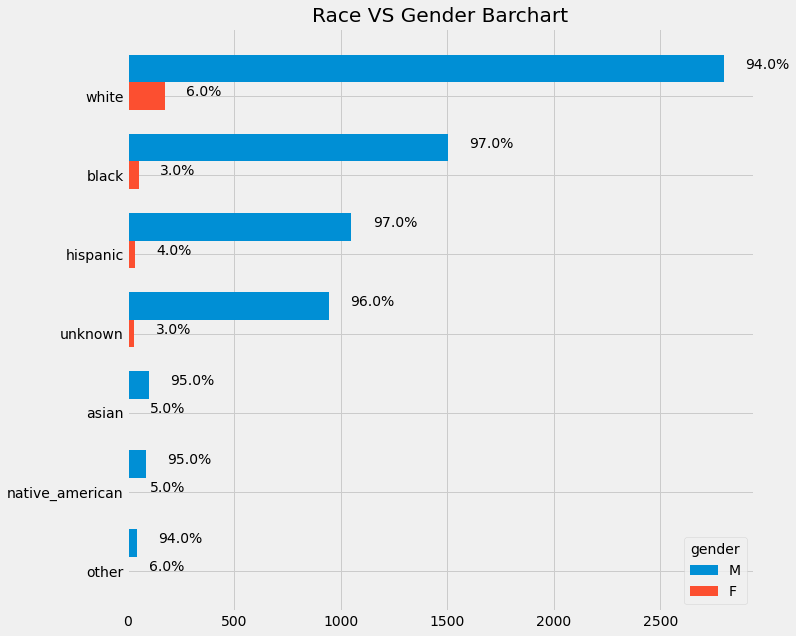

In [59]:
# SIDE BY SIDE BARCHART

height = .35

m = fps[fps.gender == 'M'].race.value_counts()[::-1]
f = fps[fps.gender == 'F'].race.value_counts()[::-1]

plt.figure(figsize=(10,10))

plt.barh(np.arange(m.index.size) + height, m, height=height, label='M')
plt.barh(np.arange(m.index.size), f, height=height, label='F')

for i in np.arange(m.index.size):
    plt.text(m.iloc[i] + 100, i + height,
             cont_table.loc[m.index[i], 'M'])
    plt.text(f.iloc[i] + 100, i,
             cont_table.loc[f.index[i], 'F'])

plt.yticks(np.arange(m.index.size), m.index)
plt.legend(loc='lower right', title='gender')
_ = plt.title('Race VS Gender Barchart')

#### • Age VS Race

No handles with labels found to put in legend.


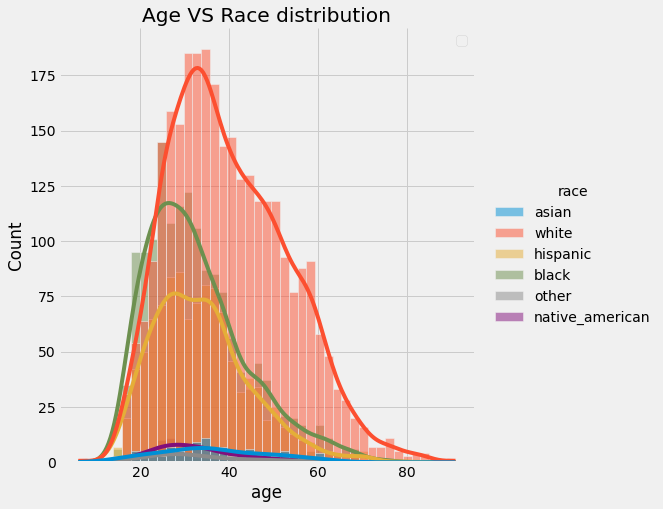

In [60]:
_ = sns.displot(data=fps[fps.race != 'unknown'], x='age', height=7, kde=True, hue='race')

plt.legend()
_ = plt.title('Age VS Race distribution')

#### • Age VS Race VS Gender

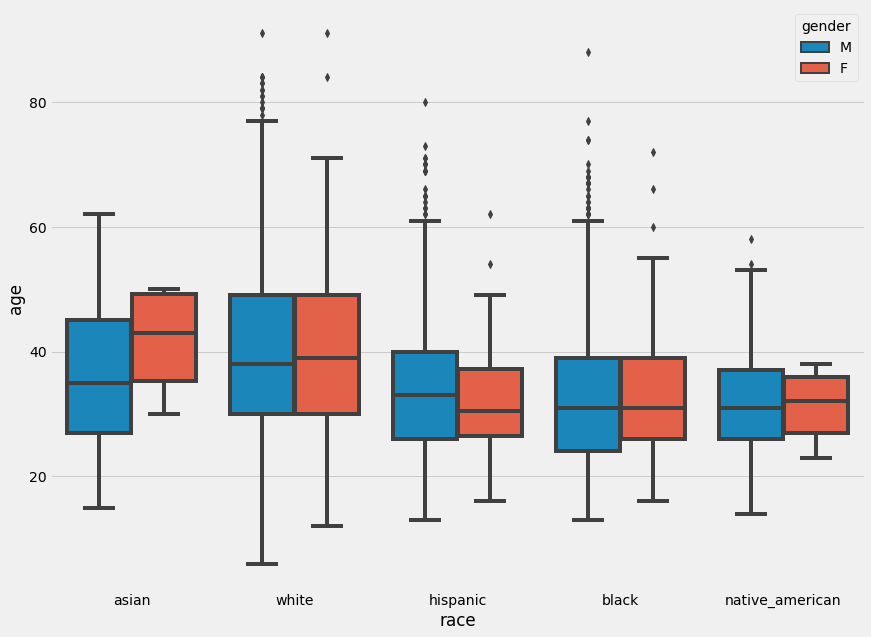

In [151]:
plt.figure(figsize=(13,10))
_ = sns.boxplot(data=fps[fps.gender.isin(['M', 'F'])], x='race', y='age', hue='gender')

### b) Victim data VS Context data

#### • Age VS Flee distribution

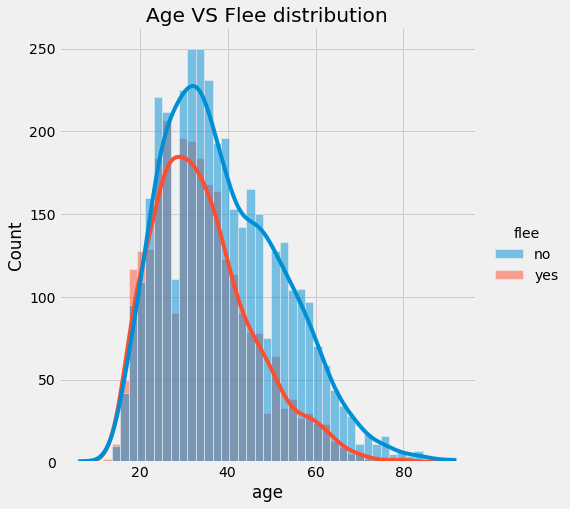

In [62]:
to_plot = fps.copy()
to_plot.flee = to_plot.flee.drop(to_plot[to_plot.flee == 'unknown'].index)
to_plot.flee = to_plot.flee.apply(lambda x: 'no' if x == 'Not fleeing' else 'yes')

_ = sns.displot(data=to_plot, x='age', height=7, kde=True, hue='flee')

_ = plt.title('Age VS Flee distribution')

#### • Age VS Armed distribution

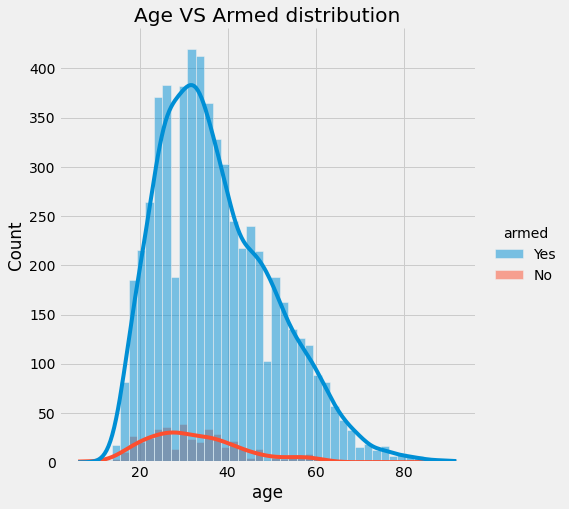

In [63]:
to_plot = fps.copy()
to_plot.armed = to_plot.armed.drop(to_plot[to_plot.armed == 'unknown'].index)
to_plot.armed = to_plot.armed.apply(lambda x: 'No' if x == 'unarmed' else 'Yes')

_ = sns.displot(data=to_plot, x='age', height=7, kde=True, hue='armed')

_ = plt.title('Age VS Armed distribution')

#### • Age VS Threat Level distribution

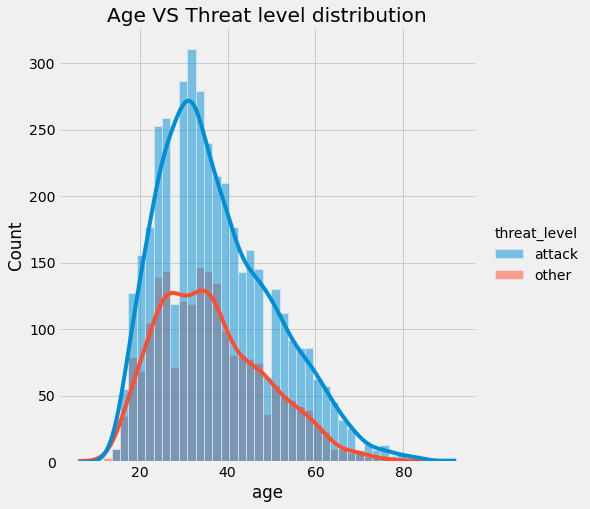

In [64]:
to_plot = fps.copy()
to_plot.threat_level = to_plot.threat_level.drop(to_plot[to_plot.threat_level == 'undetermined'].index)

_ = sns.displot(data=to_plot, x='age', height=7, kde=True, hue='threat_level')

_ = plt.title('Age VS Threat level distribution')

#### • Age VS Signs of Mental Illness distribution

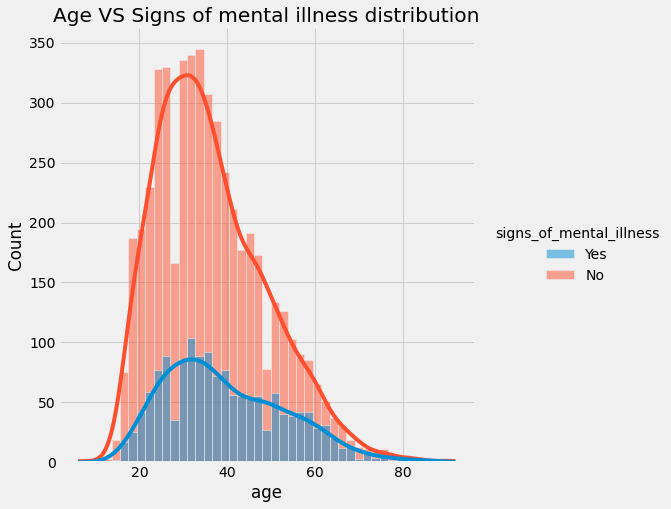

In [65]:
to_plot = fps.copy()
to_plot.signs_of_mental_illness = to_plot.signs_of_mental_illness.drop(to_plot[to_plot.signs_of_mental_illness == 'undetermined'].index)

_ = sns.displot(data=to_plot, x='age', height=7, kde=True, hue='signs_of_mental_illness')

_ = plt.title('Age VS Signs of mental illness distribution')

#### • Race VS Armed distribution

In [66]:
# CONTINGENCY TABLE

cont_table = pd.crosstab(fps.race, fps.armed_bool, normalize='index', margins=True)
cont_table = round(cont_table * 100).astype(str) + '%'
cont_table

armed_bool,No,Yes
race,,
asian,8.0%,92.0%
black,9.0%,91.0%
hispanic,8.0%,92.0%
native_american,7.0%,93.0%
other,12.0%,88.0%
unknown,2.0%,98.0%
white,6.0%,94.0%
All,7.0%,93.0%


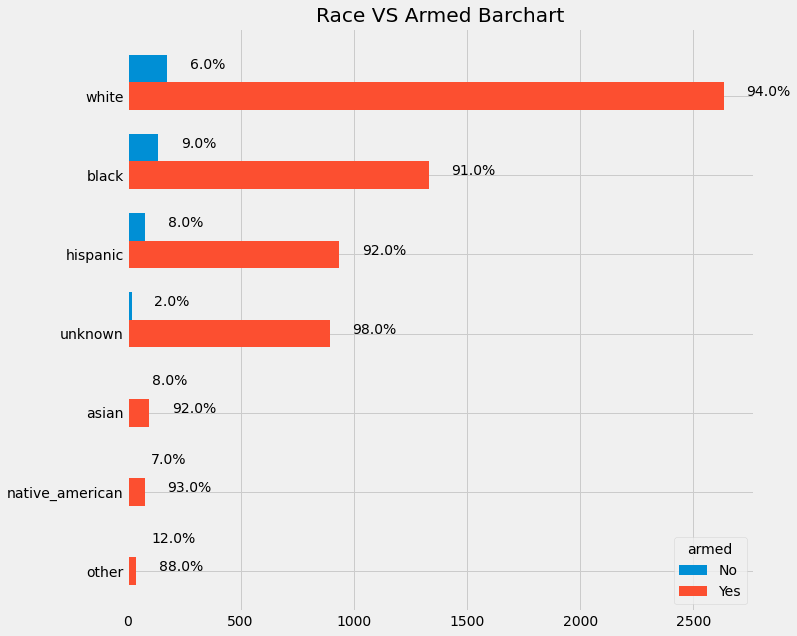

In [67]:
# SIDE BY SIDE BARCHART

yes = fps[fps.armed_bool == 'Yes'].race.value_counts()[::-1]
no = fps[fps.armed_bool == 'No'].race.value_counts()[::-1]

height = .35

plt.figure(figsize=(10,10))

plt.barh(np.arange(yes.index.size) + height, no, height=height, label='No')
plt.barh(np.arange(yes.index.size), yes, height=height, label='Yes')


for i in np.arange(yes.index.size):
    plt.text(yes.iloc[i] + 100, i,
             cont_table.loc[yes.index[i], 'Yes'])
    plt.text(no.iloc[i] + 100, i + height,
             cont_table.loc[no.index[i], 'No'])

plt.yticks(np.arange(yes.index.size), yes.index)
plt.legend(loc='lower right', title='armed')
_ = plt.title('Race VS Armed Barchart')

#### • Race VS Threat Level distribution

In [68]:
# CONTINGENCY TABLE

cont_table = pd.crosstab(fps.race, fps.threat_level, normalize='index', margins=True).drop('undetermined', axis=1)
cont_table = round(cont_table * 100).astype(str) + '%'
cont_table

threat_level,attack,other
race,,
asian,52.0%,47.0%
black,67.0%,30.0%
hispanic,59.0%,38.0%
native_american,58.0%,36.0%
other,66.0%,34.0%
unknown,63.0%,31.0%
white,66.0%,31.0%
All,64.0%,32.0%


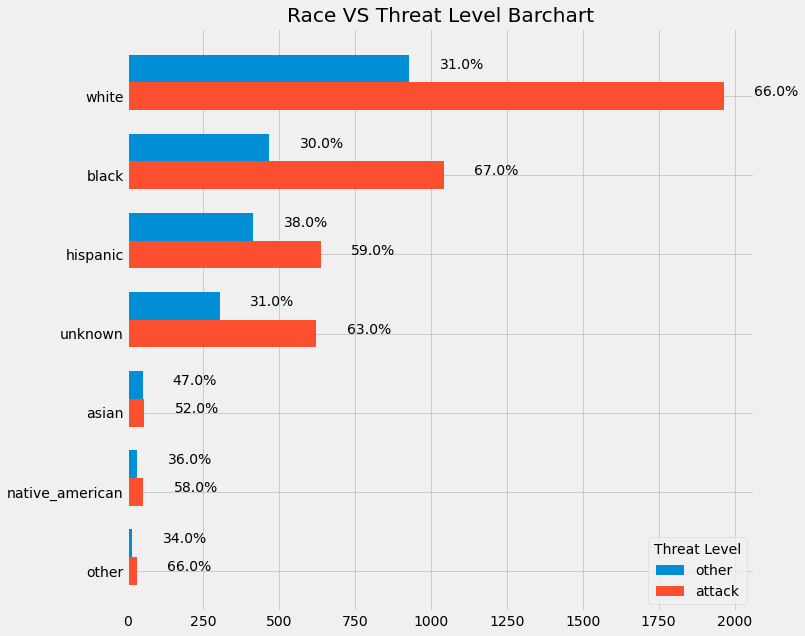

In [69]:
# SIDE BY SIDE BARCHART

yes = fps[fps.threat_level == 'attack'].race.value_counts()[::-1]
no = fps[fps.threat_level == 'other'].race.value_counts()[::-1]

height = .35

plt.figure(figsize=(10,10))

plt.barh(np.arange(yes.index.size) + height, no, height=height, label='other')
plt.barh(np.arange(yes.index.size), yes, height=height, label='attack')

for i in np.arange(yes.index.size):
    plt.text(yes.iloc[i] + 100, i,
             cont_table.loc[yes.index[i], 'attack'])
    plt.text(no.iloc[i] + 100, i + height,
             cont_table.loc[no.index[i], 'other'])

plt.yticks(np.arange(yes.index.size), yes.index)
plt.legend(loc='lower right', title='Threat Level')
_ = plt.title('Race VS Threat Level Barchart')

#### • Race VS Flee distribution

In [70]:
# CONTINGENCY TABLE

cont_table = pd.crosstab(fps.race, fps.flee_bool, normalize='index', margins=True)
cont_table = round(cont_table * 100).astype(str) + '%'
cont_table

flee_bool,No,Yes
race,,
asian,78.0%,22.0%
black,58.0%,42.0%
hispanic,62.0%,38.0%
native_american,61.0%,39.0%
other,63.0%,37.0%
unknown,62.0%,38.0%
white,69.0%,31.0%
All,64.0%,36.0%


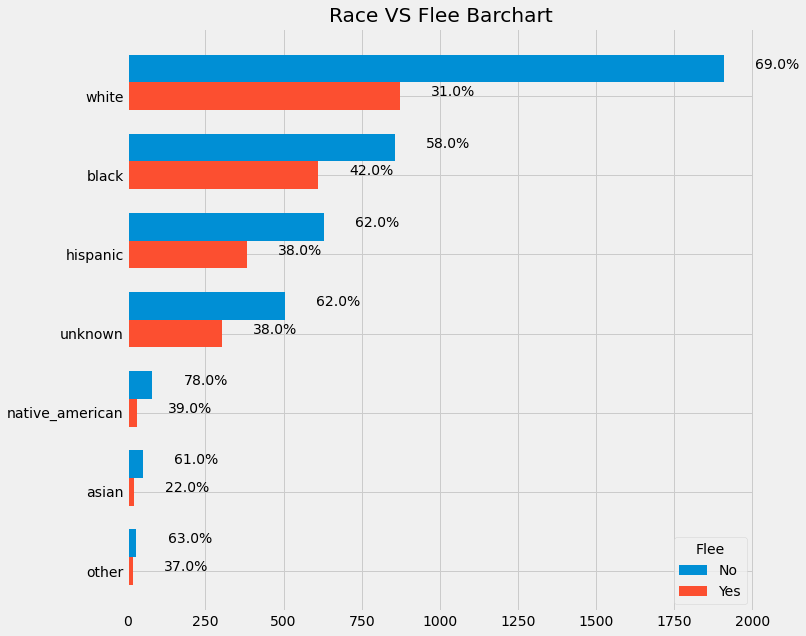

In [71]:
# SIDE BY SIDE BARCHART

yes = fps[fps.flee_bool == 'Yes'].race.value_counts()[::-1]
no = fps[fps.flee_bool == 'No'].race.value_counts()[::-1]

height = .35

plt.figure(figsize=(10,10))

plt.barh(np.arange(yes.index.size) + height, no, height=height, label='No')
plt.barh(np.arange(yes.index.size), yes, height=height, label='Yes')

for i in np.arange(yes.index.size):
    plt.text(yes.iloc[i] + 100, i,
             cont_table.loc[yes.index[i], 'Yes'])
    plt.text(no.iloc[i] + 100, i + height,
             cont_table.loc[no.index[i], 'No'])

plt.yticks(np.arange(yes.index.size), yes.index)
plt.legend(loc='lower right', title='Flee')
_ = plt.title('Race VS Flee Barchart')

#### • Race  VS Mental Illness

In [72]:
# CONTINGENCY TABLE

cont_table = pd.crosstab(fps.race, fps.signs_of_mental_illness, normalize='index', margins=True)
cont_table = round(cont_table * 100).astype(str) + '%'
cont_table

signs_of_mental_illness,No,Yes
race,,
asian,75.0%,25.0%
black,84.0%,16.0%
hispanic,82.0%,18.0%
native_american,82.0%,18.0%
other,79.0%,21.0%
unknown,82.0%,18.0%
white,71.0%,29.0%
All,78.0%,22.0%


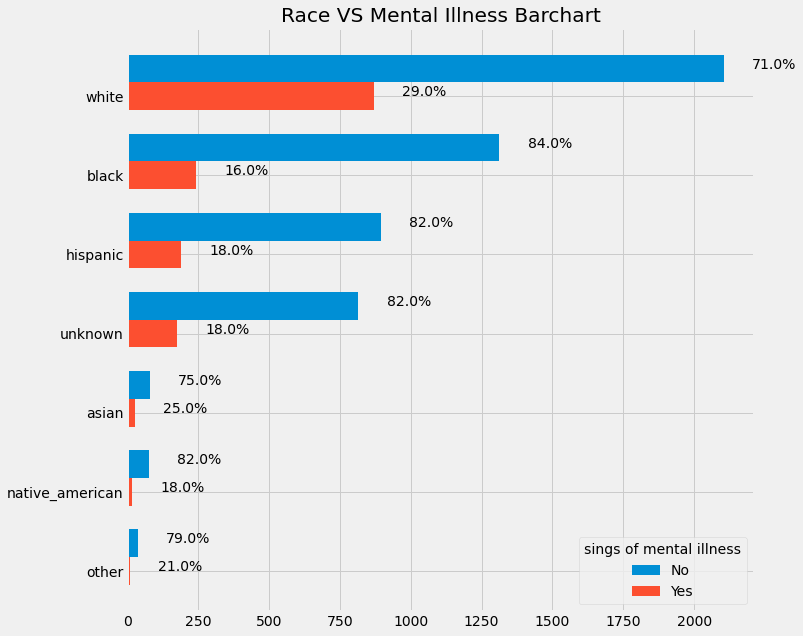

In [73]:
# SIDE BY SIDE BARCHART

height = .35

yes = fps[fps.signs_of_mental_illness == 'Yes'].race.value_counts()[::-1]
no = fps[fps.signs_of_mental_illness == 'No'].race.value_counts()[::-1]

plt.figure(figsize=(10,10))

plt.barh(np.arange(yes.index.size) + height, no, height=height, label='No')
plt.barh(np.arange(yes.index.size), yes, height=height, label='Yes')

for i in np.arange(yes.index.size):
    plt.text(yes.iloc[i] + 100, i,
             cont_table.loc[yes.index[i], 'Yes'])
    plt.text(no.iloc[i] + 100, i + height,
             cont_table.loc[no.index[i], 'No'])

plt.yticks(np.arange(yes.index.size), yes.index)
plt.legend(loc='lower right', title='sings of mental illness')
_ = plt.title('Race VS Mental Illness Barchart')

#### • Race  VS Body Cam

In [74]:
# CONTINGENCY TABLE

cont_table = pd.crosstab(fps.race, fps.body_camera, normalize='index', margins=True)
cont_table = round(cont_table * 100).astype(str) + '%'
cont_table

body_camera,No,Yes
race,,
asian,80.0%,20.0%
black,81.0%,19.0%
hispanic,85.0%,15.0%
native_american,82.0%,18.0%
other,87.0%,13.0%
unknown,87.0%,13.0%
white,89.0%,11.0%
All,86.0%,14.0%


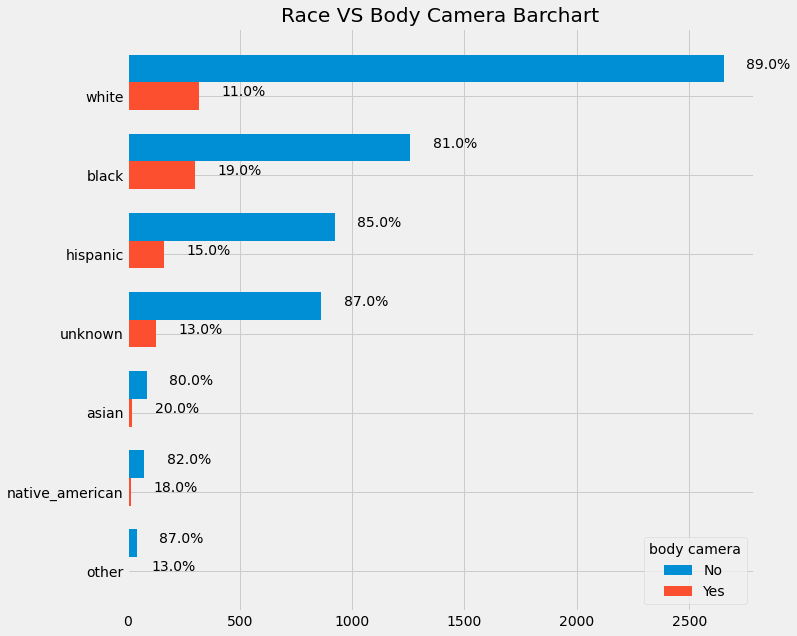

In [75]:
# SIDE BY SIDE BARCHART

height = .35

yes = fps[fps.body_camera == 'Yes'].race.value_counts()[::-1]
no = fps[fps.body_camera == 'No'].race.value_counts()[::-1]

plt.figure(figsize=(10,10))

plt.barh(np.arange(yes.index.size) + height, no, height=height, label='No')
plt.barh(np.arange(yes.index.size), yes, height=height, label='Yes')

for i in np.arange(yes.index.size):
    plt.text(yes.iloc[i] + 100, i,
             cont_table.loc[yes.index[i], 'Yes'])
    plt.text(no.iloc[i] + 100, i + height,
             cont_table.loc[no.index[i], 'No'])

plt.yticks(np.arange(yes.index.size), yes.index)
plt.legend(loc='lower right', title='body camera')
_ = plt.title('Race VS Body Camera Barchart')

# Data Transformation

## --> FPS per million

In [76]:
cities = pd.merge(fps.groupby(['state', 'city']).id.count(), cities, how='left', on=['state', 'city']).rename(columns={'id': 'num_fps'})

In [77]:
cities[cities.population == 0]

,,num_fps,population,lat,lng,share_white,share_black,share_native_american,share_asian,share_hispanic,poverty_rate,percent_completed_hs,Median Income
state,city,,,,,,,,,,,,
WI,Odanah,1,0.0,46.6121,-90.6992,0.0,0.0,100.0,0.0,7.7,71.4,100.0,50393.407432


In [78]:
cities = cities.drop(cities.loc[('WI', 'Odanah')].index) # elimino città con 0 abitanti per evitare divisione per 0

cities['fps_per_million'] = cities.apply(lambda x: (x.num_fps/x.population)*1000000, axis=1)

In [79]:
cities.head()

num_fps  population      lat       lng  share_white  \
state city                                                                 
AK    Anchor Point         1      2057.0  59.7703 -151.7052         90.2   
      Anchorage           11    253421.0  61.1508 -149.1091         66.0   
      Barrow               1      4178.0      NaN       NaN         16.9   
      Big Lake             1      3136.0  61.5260 -149.9721         86.1   
      Copper Center        1       397.0  61.9845 -145.3544         45.7   

                     share_black  share_native_american  share_asian  \
state city                                                             
AK    Anchor Point           0.3                    3.8          0.9   
      Anchorage              5.6                    7.9          8.1   
      Barrow                 1.0                   61.2          9.1   
      Big Lake               0.2                    7.0          0.5   
      Copper Center          0.0                   48.5          0.3   

                     share_hispanic  poverty_rate  percent_completed_hs  \
state city                                                                
AK    Anchor Point              2.2          10.1                  93.8   
      Anchorage                 7.6           8.2                  93.0   
      Barrow                    3.1          11.7                  84.6   
      Big Lake                  3.1           9.6                  90.4   
      Copper Center             3.0          18.8                  84.8   

                     Median Income  fps_per_million  
state city                                           
AK    Anchor Point         51591.0       486.144871  
      Anchorage            78326.0        43.406032  
      Barrow               76902.0       239.348971  
      Big Lake             70988.0       318.877551  
      Copper Center        39063.0      2518.891688

## --> FPS per million by race

$ victims\ per\ million = \frac{victims_{race}}{share_{race} \ \times \ population} \times 10^6 $

In [80]:
pop_tot = cities.population.sum()
share_race_mean = cities[['share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']].mean()
share_race_mean = pd.DataFrame(share_race_mean.sort_index(), columns=['share'])

fps = fps.drop(fps[(fps.race == 'other') | (fps.race == 'unknown')].index)

victims_per_race = fps.groupby('race').aggregate({'id': 'count'}) # , 'menace': np.sum # qui
share_race_mean.index = victims_per_race.index

In [81]:
victims_vs_share = pd.concat([victims_per_race, share_race_mean], axis=1)
victims_vs_share = victims_vs_share.rename(columns={'id': 'num_fps'})
victims_vs_share.head()

,num_fps,share
race,,
asian,107,2.949401
black,1557,11.968160
hispanic,1084,14.271442
native_american,91,2.074851
white,2974,74.458399


In [82]:
def victims_per_million_func(row):
    try:
        x = (row.num_fps / (row.share * pop_tot)) * 1000000 
    except ZeroDivisionError:
        x = np.nan
    
    return x

victims_per_million = victims_vs_share.apply(victims_per_million_func, axis=1)
victims_per_million.head()

race
asian              0.113023
black              0.405301
hispanic           0.236634
native_american    0.136638
white              0.124435
dtype: float64

## --> FPS per million by race per day

In [83]:
victims_per_million_per_day = fps.groupby(['date', 'race']).aggregate({'id': 'count'}).unstack(fill_value=0).apply(lambda x: x.id, axis=1)
victims_per_million_per_day.head()

race,asian,black,hispanic,native_american,white
date,,,,,
2015-01-02,1,0,0,0,1
2015-01-03,0,0,1,0,0
2015-01-04,0,0,1,0,2
2015-01-05,0,0,1,0,0
2015-01-06,0,1,0,0,3


In [84]:
def victims_per_million_per_day_func(x):
    race = x.name
    return (x / (victims_vs_share.share[race] * pop_tot)) * 1000000

victims_per_million_per_day = victims_per_million_per_day.apply(victims_per_million_per_day_func, axis=0)
victims_per_million_per_day.head()

race,asian,black,hispanic,native_american,white
date,,,,,
2015-01-02,0.001056,0.00000,0.000000,0.0,0.000042
2015-01-03,0.000000,0.00000,0.000218,0.0,0.000000
2015-01-04,0.000000,0.00000,0.000218,0.0,0.000084
2015-01-05,0.000000,0.00000,0.000218,0.0,0.000000
2015-01-06,0.000000,0.00026,0.000000,0.0,0.000126


# Data Visualization

In [85]:
# stati

states = cities.reset_index(level=0).groupby('state')[['fps_per_million', 'poverty_rate', 'percent_completed_hs', 'Median Income']].mean().sort_values('fps_per_million', ascending=False)
states.head()

,fps_per_million,poverty_rate,percent_completed_hs,Median Income
state,,,,
CO,2020.012883,13.701728,89.084937,59431.117248
WI,998.179281,14.140984,90.032939,48101.486387
MD,826.826011,11.388917,88.511161,72291.509805
AK,792.470152,15.647721,87.476786,55023.876845
WV,737.052707,21.634318,84.693451,38193.700885


<AxesSubplot:>

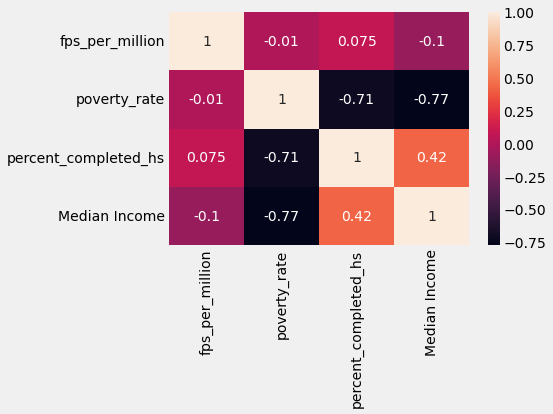

In [86]:
# correlation matrix

sns.heatmap(states.corr(), annot=True)

In [118]:
# normalizzazione

states.poverty_rate = states.poverty_rate / states.poverty_rate.max()
states.percent_completed_hs = states.percent_completed_hs / states.percent_completed_hs.max()
states.fps_per_million = states.fps_per_million / states.fps_per_million.max()
states['Median Income'] = states['Median Income'] / states['Median Income'].max()

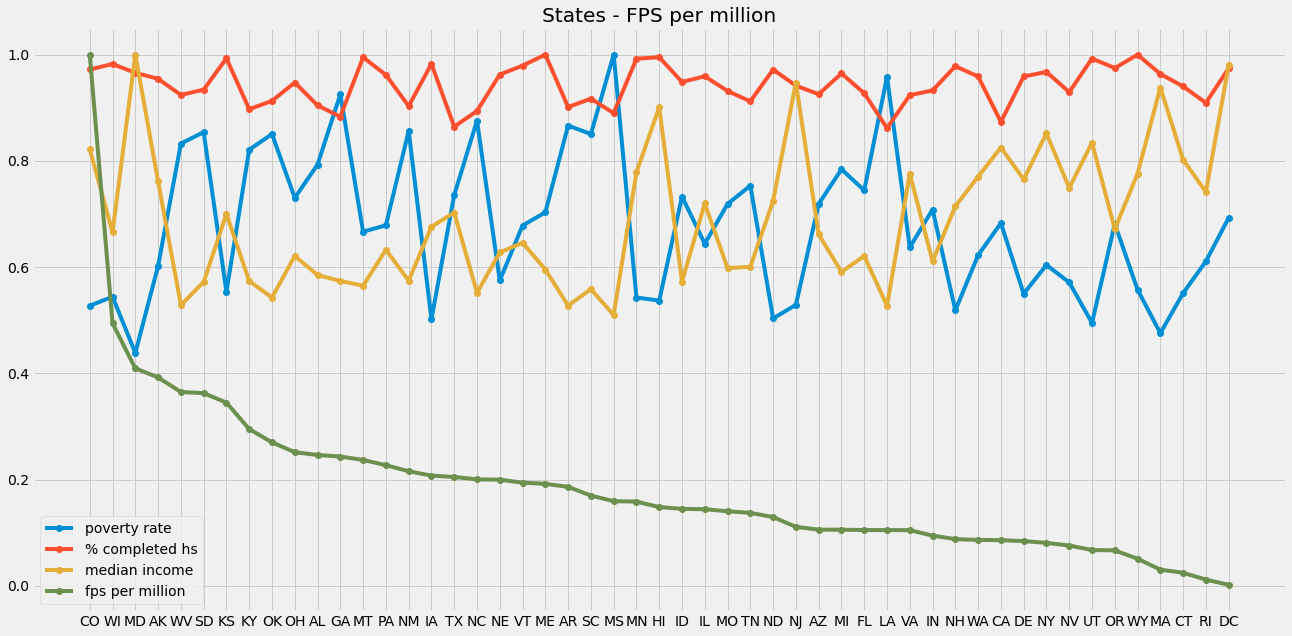

In [119]:
plt.figure(figsize=(20,10))

plt.plot(states.poverty_rate, label='poverty rate', marker='o')
plt.plot(states.percent_completed_hs, label='% completed hs', marker='o')
plt.plot(states['Median Income'], label='median income', marker='o')
plt.plot(states.fps_per_million, label='fps per million', marker='o')
_ = plt.legend()
_ = plt.title('States - FPS per million')

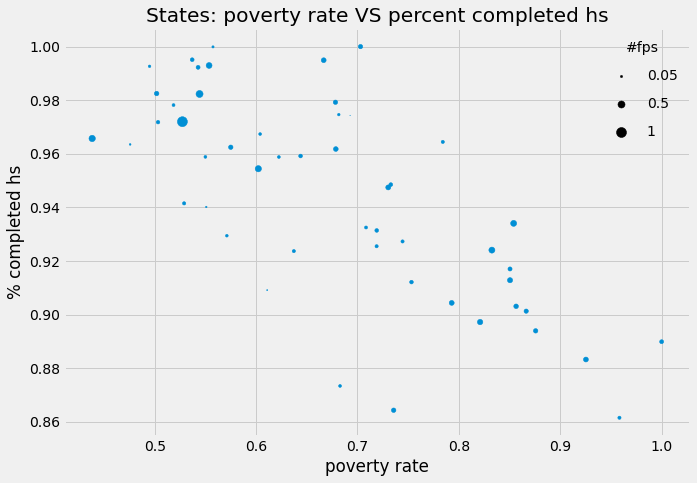

In [120]:
plt.figure(figsize=(10,7))

plt.scatter(states.poverty_rate, states.percent_completed_hs, s=states.fps_per_million*100)
plt.xlabel('poverty rate')
plt.ylabel('% completed hs')
plt.title('States: poverty rate VS percent completed hs')

for area in [.05, .5, 1]:
    plt.scatter([], [], c='k', alpha=1, s=area*100,
                label=str(area))

_ = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='#fps')

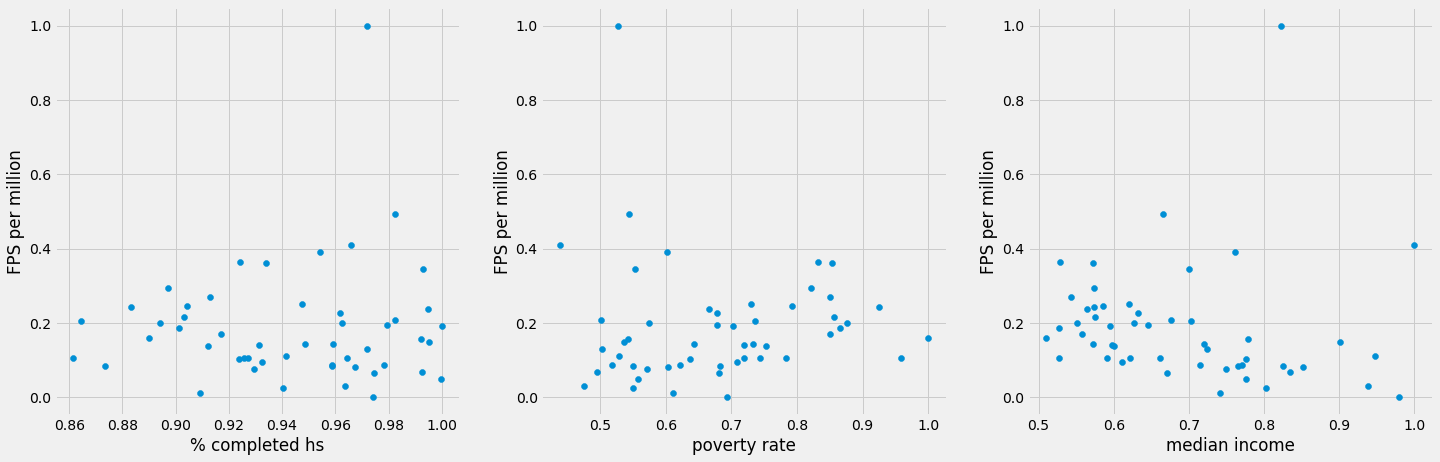

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(22, 7))

_ = ax[0].scatter(states.percent_completed_hs, states.fps_per_million)
_ = ax[0].set_xlabel('% completed hs')
_ = ax[0].set_ylabel('FPS per million')

_ = ax[1].scatter(states.poverty_rate, states.fps_per_million)
_ = ax[1].set_xlabel('poverty rate')
_ = ax[1].set_ylabel('FPS per million')

_ = ax[2].scatter(states['Median Income'], states.fps_per_million)
_ = ax[2].set_xlabel('median income')
_ = ax[2].set_ylabel('FPS per million')

In [91]:
# città più pericolose

most_dangerous_cities = cities.drop(['num_fps', 'lat', 'lng', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic'], axis=1).copy()
most_dangerous_cities.head()

population  poverty_rate  percent_completed_hs  \
state city                                                            
AK    Anchor Point       2057.0          10.1                  93.8   
      Anchorage        253421.0           8.2                  93.0   
      Barrow             4178.0          11.7                  84.6   
      Big Lake           3136.0           9.6                  90.4   
      Copper Center       397.0          18.8                  84.8   

                     Median Income  fps_per_million  
state city                                           
AK    Anchor Point         51591.0       486.144871  
      Anchorage            78326.0        43.406032  
      Barrow               76902.0       239.348971  
      Big Lake             70988.0       318.877551  
      Copper Center        39063.0      2518.891688

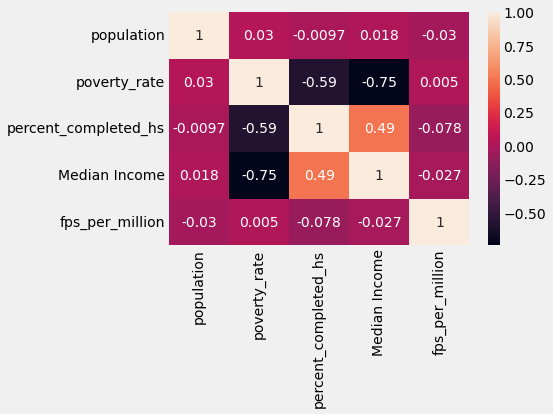

In [121]:
# correlation matrix

_ = sns.heatmap(most_dangerous_cities.corr(), annot=True)

In [93]:
# normalizzazione

most_dangerous_cities = most_dangerous_cities / most_dangerous_cities.max()

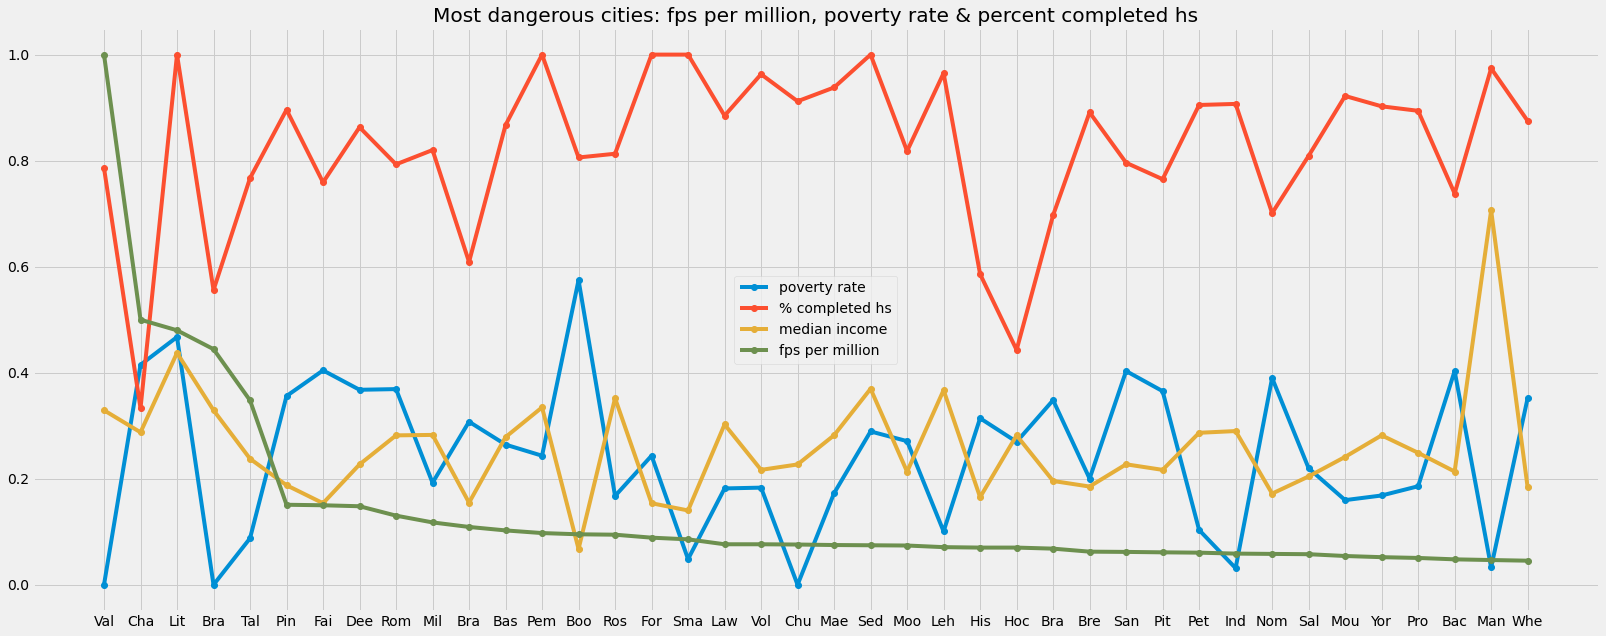

In [94]:
to_plot = most_dangerous_cities.sort_values('fps_per_million', ascending=False).head(40).reset_index(level=0)

plt.figure(figsize=(25,10))

plt.plot(to_plot.poverty_rate, label='poverty rate', marker='o')
plt.plot(to_plot.percent_completed_hs, label='% completed hs', marker='o')
plt.plot(to_plot['Median Income'], label='median income', marker='o')
plt.plot(to_plot.fps_per_million, label='fps per million', marker='o')

plt.legend()
plt.title('Most dangerous cities: fps per million, poverty rate & percent completed hs')
_ = plt.xticks(ticks=np.arange(40), labels=to_plot.index.str[:3])

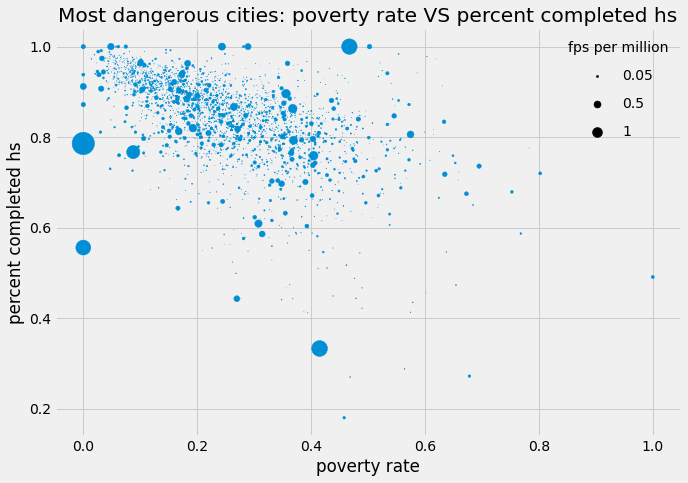

In [122]:
plt.figure(figsize=(10,7))

plt.scatter(most_dangerous_cities.poverty_rate, most_dangerous_cities.percent_completed_hs, s=most_dangerous_cities.fps_per_million*500)
plt.xlabel('poverty rate')
plt.ylabel('percent completed hs')
plt.title('Most dangerous cities: poverty rate VS percent completed hs')

for area in [.05, .5, 1]:
    plt.scatter([], [], c='k', alpha=1, s=area*100,
                label=str(area))

_ = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='fps per million')

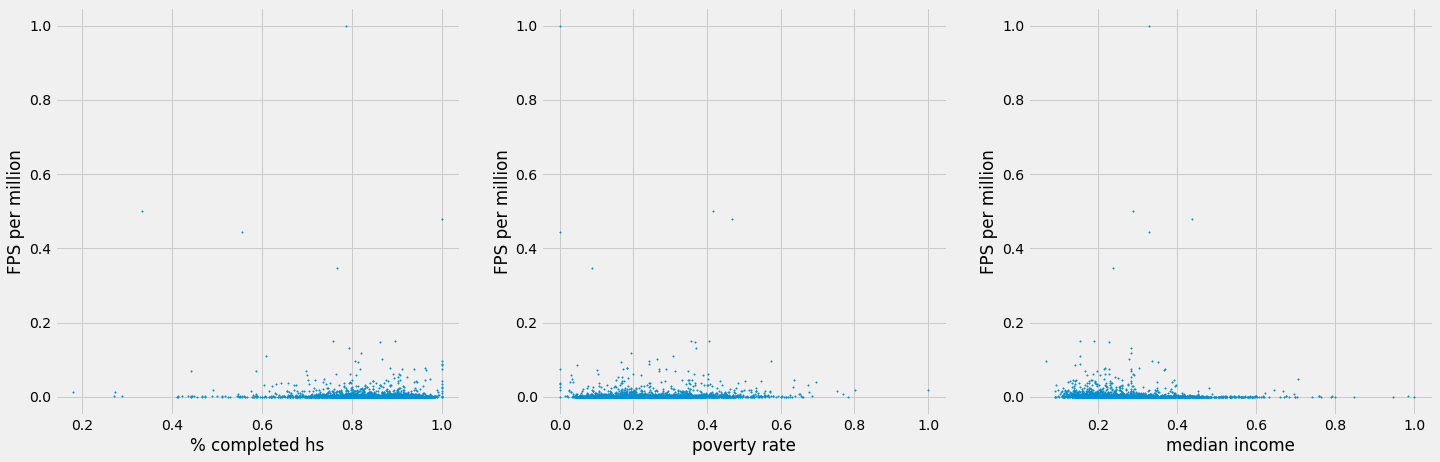

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(22, 7))

_ = ax[0].scatter(most_dangerous_cities.percent_completed_hs, most_dangerous_cities.fps_per_million, s=2)
_ = ax[0].set_xlabel('% completed hs')
_ = ax[0].set_ylabel('FPS per million')

_ = ax[1].scatter(most_dangerous_cities.poverty_rate, most_dangerous_cities.fps_per_million, s=2)
_ = ax[1].set_xlabel('poverty rate')
_ = ax[1].set_ylabel('FPS per million')

_ = ax[2].scatter(most_dangerous_cities['Median Income'], most_dangerous_cities.fps_per_million, s=2)
_ = ax[2].set_xlabel('median income')
_ = ax[2].set_ylabel('FPS per million')

There are no apparent correlations between FPS per million and graduation rate, poverty rate, median income (conversely, there seem to be a weak negative correlation between poverty rate and graduation rate).

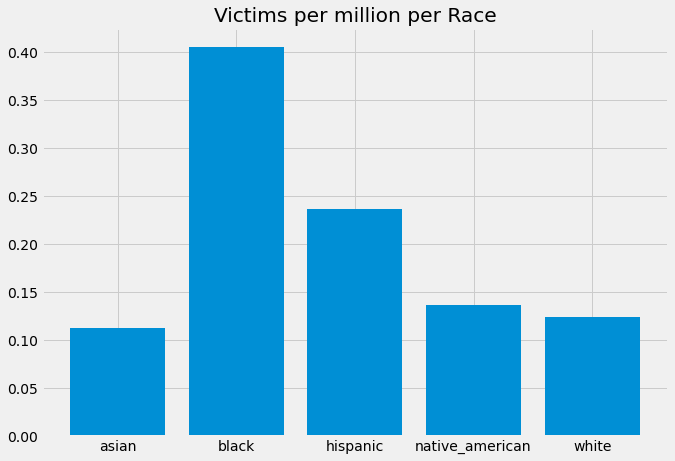

In [97]:
# VICTIMS PER MILLION (BY RACE)

plt.figure(figsize=(10,7))
plt.bar(victims_per_million.index, victims_per_million.values)

_ = plt.title('Victims per million per Race')

Considering the number of victims per million per ethnic group, is evident how data are strongly biased towards hispanic and (specially) black ethnic groups.

## Historical Evolution

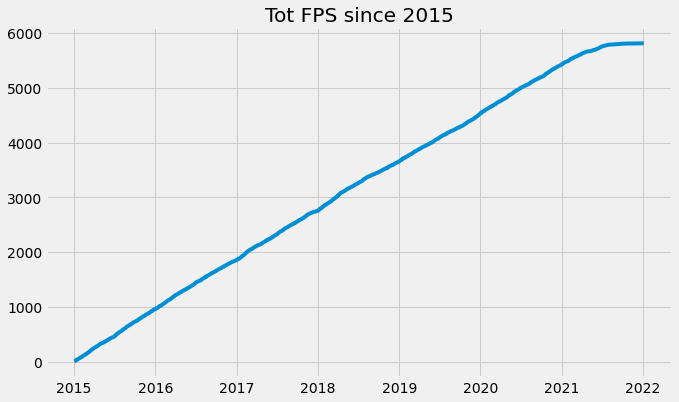

In [98]:
# PLOT: Tot FPS since 2015

fps_per_day = fps.groupby('date')['id'].count()
fps_per_day.index = pd.to_datetime(fps_per_day.index)

_ = plt.figure(figsize=(10,6))
_ = plt.plot(np.add.accumulate(fps_per_day))
_ = plt.title('Tot FPS since 2015')

In [124]:
# FREQUENCY TABLE

freq_table = freqTable(fps.year[fps.year < 2022], show=False)
freq_table.sort_index()

,count,perc
year,,
2015,958,16.48%
2016,894,15.38%
2017,901,15.5%
2018,899,15.47%
2019,877,15.09%
2020,898,15.45%
2021,385,6.62%


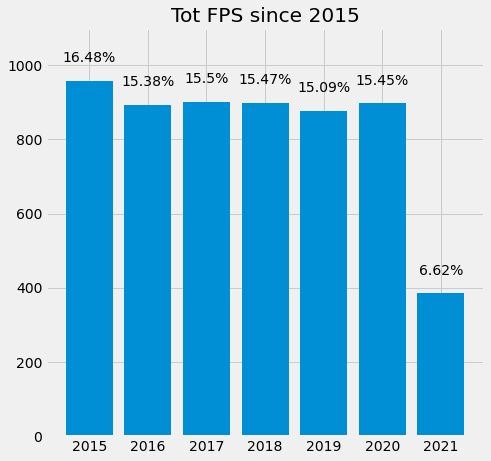

In [127]:
# BARCHART

barchart(freq_table)
_ = plt.title('Tot FPS since 2015')
_ = plt.ylim(0, 1100)

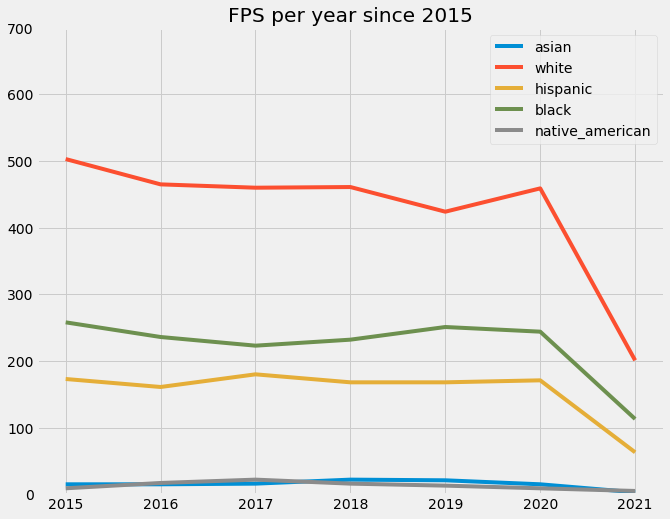

In [101]:
# PLOT: FPS since 2015 per race

plt.figure(figsize=(10,8))

for race in fps.race.unique():
    to_plot = fps[(fps['race'] == race) & (fps['year']<2022)].groupby('year')['id'].count()
    plt.plot(to_plot, label=race)
    
plt.legend()
_ = plt.title('FPS per year since 2015')
_ = plt.ylim(0, 700)

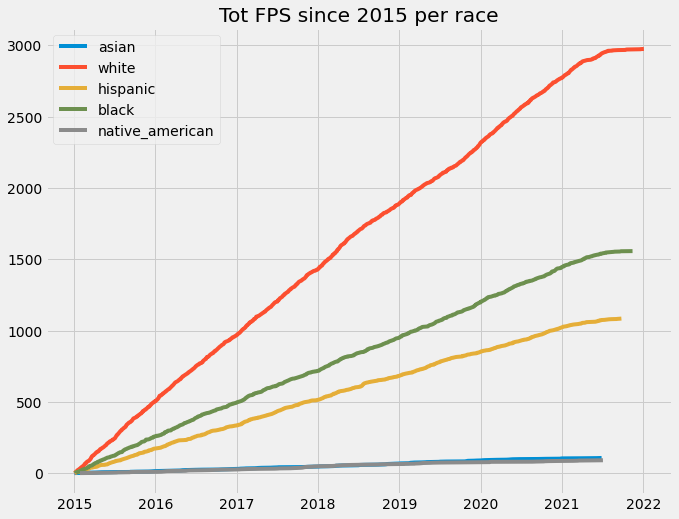

In [102]:
# PLOT: Tot FPS since 2015 per race

plt.figure(figsize=(10,8))

for race in fps.race.unique():  
    to_plot = fps[fps['race'] == race].groupby('date')['id'].count()
    to_plot.index = pd.to_datetime(to_plot.index)
    plt.plot(np.add.accumulate(to_plot), label=race)
    
_ = plt.title('Tot FPS since 2015 per race')
_ = plt.legend()

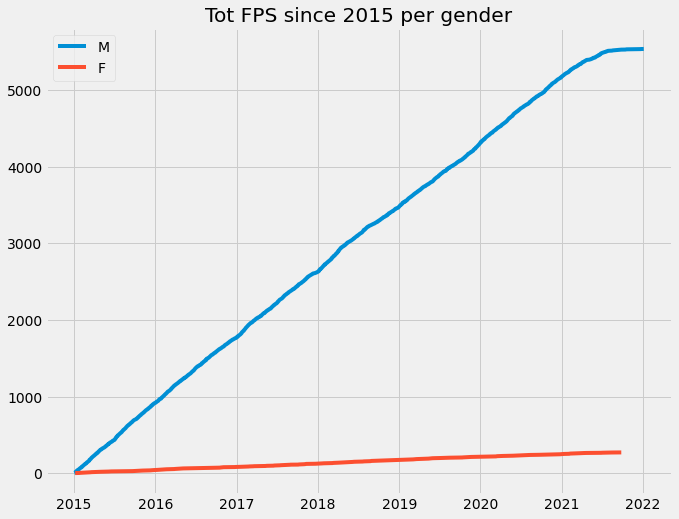

In [103]:
# PLOT: Tot FPS since 2015

plt.figure(figsize=(10,8))

for gender in ['M', 'F']:
    to_plot = fps[fps['gender'] == gender].groupby('date')['id'].count()
    to_plot.index = pd.to_datetime(to_plot.index)
    plt.plot(np.add.accumulate(to_plot), label=gender)

_ = plt.title('Tot FPS since 2015 per gender')
_ = plt.legend()

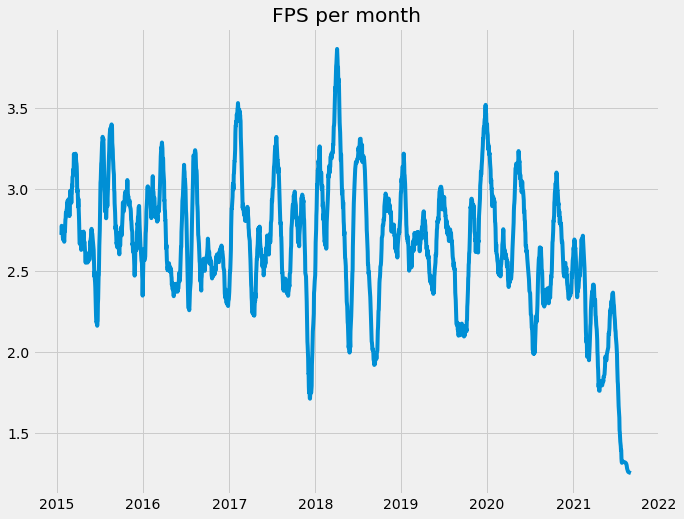

In [152]:
# PLOT: FPS per month

plt.figure(figsize=(10,8))

to_plot = fps.groupby('date')['id'].count()
to_plot.index = pd.to_datetime(to_plot.index)

plt.plot(to_plot.rolling(30, center=True, win_type='gaussian').mean(std=10))
_ = plt.title('FPS per month')

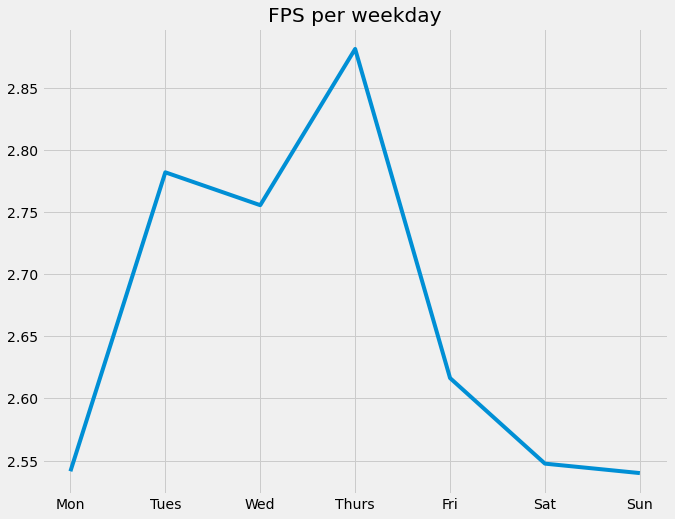

In [105]:
# FPS per weekday

data = fps.groupby('date').id.count()
by_weekday = data.groupby(data.index.dayofweek).mean()  # NB: data.index.dayofweek == data.index.weekday
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

by_weekday.plot(figsize=(10, 8))
_ = plt.title('FPS per weekday')

### --> PER MILLION

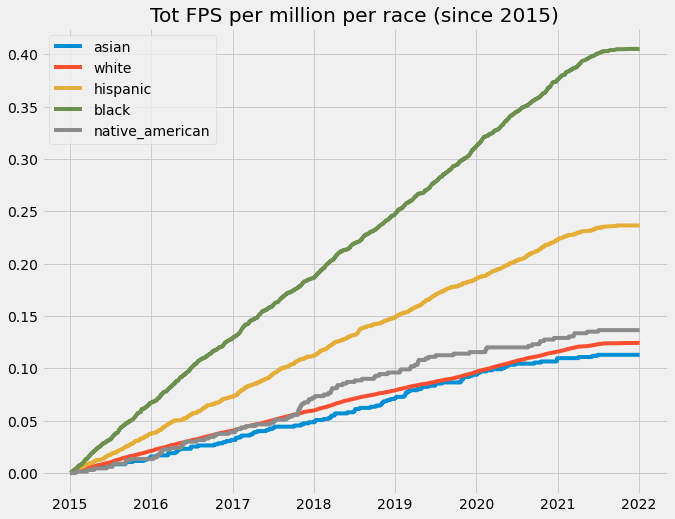

In [107]:
# PLOT: Tot FPS since 2015

plt.figure(figsize=(10,8))

for race in fps.race.unique():
    plt.plot(np.add.accumulate(victims_per_million_per_day[race]), label=race)

_ = plt.title('Tot FPS per million per race (since 2015)')
_ = plt.legend()

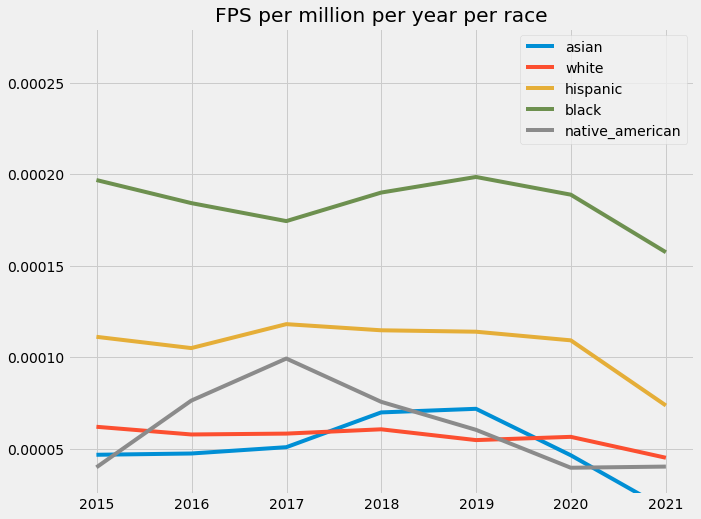

In [108]:
# PLOT: FPS per year

plt.figure(figsize=(10,8))

for race in fps.race.unique():
    plt.plot(victims_per_million_per_day[race][:'2021'].resample('Y', closed='left', label='left').mean(), label=race)

_ = plt.legend()
_ = plt.title('FPS per million per year per race')
_ = plt.ylim(.000025, .00028)

- FPS per year remained about constant between 2015 and 2020, then had a strong decline in 2021 (over 57%). In fact, annual grow is slowing down after 2020.
- No particular seasonality emerges, even if, on average, Wednesdays, Thursdays and Fridays are considerably more affected by the phenomenon than the rest of the week.
- Considering the number of FPS per million for each ethnicity, it appears that for the Hispanic and (in particular) African American ethnic groups there is a much faster growth before 2021 than the others, and at the same time there is a faster decrease for the same ethnic groups after 2020.

## Geographic Distribution

In [133]:
gdf = geopandas.GeoDataFrame(fps, geometry=geopandas.points_from_xy(fps.longitude, fps.latitude)) # https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html

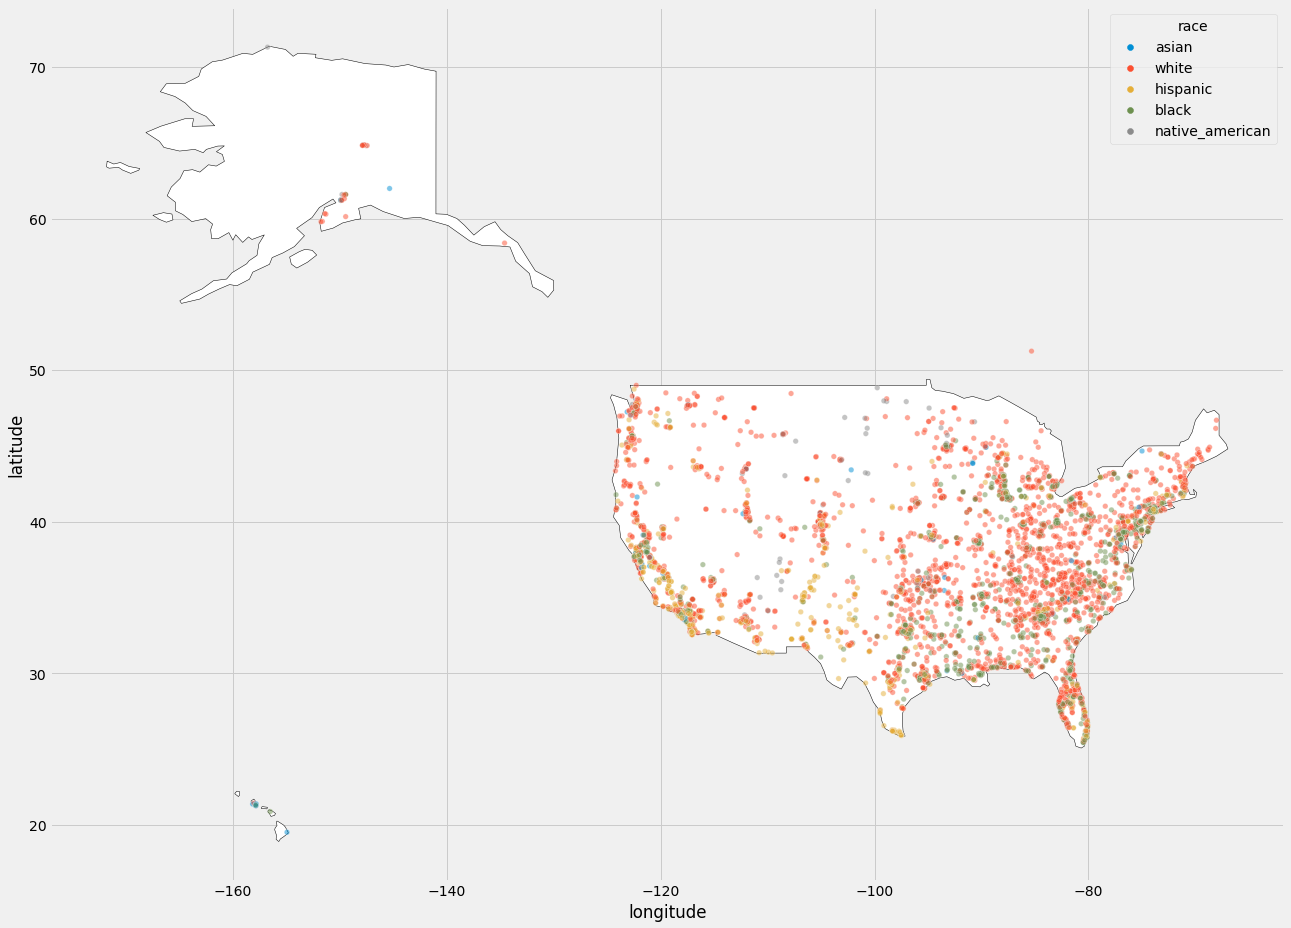

In [134]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == 'United States of America']

usa.plot(color='white', edgecolor='black', figsize=(25,15))

_ = sns.scatterplot(data=gdf, x='longitude', y='latitude', hue='race', alpha=.5, s=30) # size='gender' 